In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from MPCProblem import MPCProblem
from util import *
import cvxpy as cp
import warnings
import itertools
import time
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
import graphviz
import pydotplus
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.metrics import brier_score_loss
from scipy import stats
import matplotlib.dates as md
warnings.filterwarnings('ignore')

In [2]:
# change also perfect...
def MPC(Rmax, ramp_rate, NL, LT): # hefs_ep hefs exceendance probability

    # Rmax = 150 * kcfs_to_tafd # ~150,000 cfs
    # ramp_rate = 50 * kcfs_to_tafd # limit in either direction, per day ~5,000 cfs
    # this ramping value does not change the results much
    full_output = True
    
    run_synth = False
    site = 'ORDC1'
    # NL = 14 # could use up to 30
    start_date = '1996-12-01' 
    end_date = '1997-02-14' # model runs until (end_date - NL)
    
    df = pd.read_csv('data/Qobs.csv', index_col=0, parse_dates=True)
    df_median = calc_obs_medians(df) # for baseline only
    
    Q = df.loc[start_date:end_date, site].values * kcfs_to_tafd
    Q_median = df_median.loc[start_date:end_date, site].values * kcfs_to_tafd
    
    ds = xr.open_dataset('data/Qf-hefs.nc')
    da = ds['hefs'].sel(site=2, lead=slice(0,NL-1), ensemble=0, date=slice(start_date, end_date))
    Qf_hefs = da.values * kcfs_to_tafd # date, trace, lead

    # alter Qf_hefs....
    for t in range(len(Qf_hefs))[0:62]:
        Qf_hefs[t, :, (LT):14] = Q_median[(t+1+LT):(t+1+NL)] # replace forecast stuff with Q_median, LT = 15 means do nothing alteration
    
    
    NE, NL = Qf_hefs[0,:,:].shape
    
    problems = {'baseline': get_baseline_forecast(Q, Q_median, NL),
                'perfect': get_perfect_forecast_LT(Q, Q_median, NL, LT),
                'hefs': Qf_hefs}
    
    # synthetic forecasts - do not load until running
    if run_synth:
      # ds_syn = xr.open_dataset('data/Qf-syn.nc')
      ds_syn = xr.open_dataset('data/Qf-syn_pcnt=0.99_ORDC1_5fold.nc')
      da_syn = ds_syn['syn'].sel(site=2, lead=slice(0,NL-1), date=slice(start_date, end_date))
      num_syn = ds_syn['syn'].shape[-1]
    
      for i in range(num_syn):
        problems['syn_%d' % i] = None

    else:
      num_syn = 0
    
    res_df = pd.DataFrame({'Q': Q}, index=df.loc[start_date:end_date].index)

    # store P
    P_list = []
    for k in problems.keys():
    
      if 'syn' not in k:
        _Qf = problems[k]
      else:
        i = int(k.split('_')[1])
        _Qf = da_syn.sel(ensemble=i).values * kcfs_to_tafd
    
      P = MPCProblem(u_max = Rmax,
                     TOCS = np.zeros(NL),
                     Q = Q,
                     Qf = _Qf, 
                     ramp_rate = ramp_rate,
                     full_output = full_output)
    
      P.run(verbose=True)
      P_list.append(P)    
      res_df['R_%s' % k] = P.R
      res_df['S_%s' % k] = P.S
    
      if full_output:
        res_df['status_%s' % k] = P.status
        res_df['obj_%s' % k] = P.obj
        res_df['ESf_%s' % k] = P.Sf_post[:,:,-1].mean(axis=1)
        # can't save full uf,Sf in 2D dataframe

    
    # model only runs up to (end_date - NL)
    model_end_date = pd.to_datetime(end_date) -  pd.to_timedelta(14, unit='d')
    res_df = res_df[:model_end_date]
    # res_df.to_csv('test_results.csv')

    return res_df, P_list

# Load the model results..
Rmax = 150 * kcfs_to_tafd
ramp_rate = 50 * kcfs_to_tafd
NL = 14
LT = 14

site = 'ORDC1'

# NL = 14 # could use up to 30
start_date = '1996-12-01' 
end_date = '1997-02-14' # model runs until (end_date - NL)

df = pd.read_csv('data/Qobs.csv', index_col=0, parse_dates=True)
df_median = calc_obs_medians(df) # for baseline only

Q = df.loc[start_date:end_date, site].values * kcfs_to_tafd
Q_median = df_median.loc[start_date:end_date, site].values * kcfs_to_tafd

ds = xr.open_dataset('data/Qf-hefs.nc')
da = ds['hefs'].sel(site=2, lead=slice(0,NL-1), ensemble=0, date=slice(start_date, end_date))
Qf_hefs = da.values * kcfs_to_tafd # date, trace, lead

res_df, P_list = MPC(Rmax, ramp_rate, NL, LT)

res_df.index.name = None

In [3]:
# army corp oroville data
df_obs = pd.read_csv('data/oro_wy1997_csvdata.csv', index_col = 0, parse_dates = True)
df_obs.columns

# res_df = pd.read_csv('res_df_bench_mark.csv', index_col = 0, parse_dates = True)

start_date = '1996-12-01' 
end_date = '1997-02-14'

# cols
cols = ['Inflow (cfs)','Outflow (cfs)', 'Total Release to Feather R (cfs; elev 140 ft)',
       'Storage (ac-ft)',]


# convert to TAF
df_obs_selected = df_obs['1996-12-01':'1997-02-01'][cols]
df_obs_selected[cols[0:3]] = df_obs_selected[cols[0:3]] * 0.001 * kcfs_to_tafd
df_obs_selected[cols[3]] = df_obs_selected[cols[3]] / 1000
df_obs_selected.index = res_df.loc[start_date:end_date].index + pd.Timedelta(days = 1)

S_baseline    733.436208
S_perfect       5.741374
S_hefs          5.741374
dtype: float64


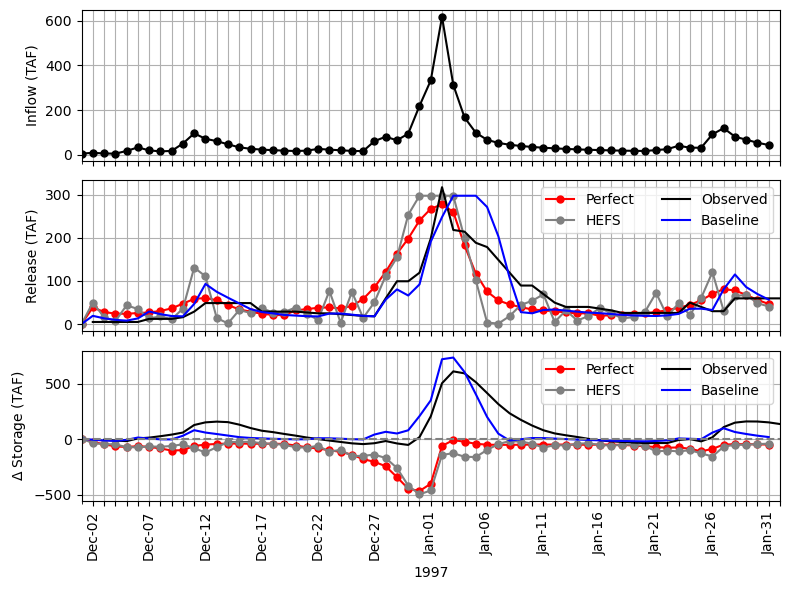

In [4]:
fig, ax = plt.subplots(3,1, sharex = True, figsize = (8,6))

# df_obs_selected[cols[0]].plot(ax = ax[0])
res_df['Q'].plot(ax = ax[0], marker = "o", color = 'black', markersize = 5)

res_df[['R_perfect', 'R_hefs']].plot(ax = ax[1], marker = "o", markersize = 5, color = ['red', 'gray'])

df_obs_selected[cols[2]].plot(ax = ax[1], color = 'black') # observed

res_df['R_baseline'].plot(color = "blue", ax = ax[1])


ax[1].legend(['Perfect', 'HEFS', 'Observed', 'Baseline'], ncol = 2)

res_df[['S_perfect', 'S_hefs']].plot(ax = ax[2], marker = "o", markersize = 5, color = ['red', 'gray'])

df_obs_selected[cols[3]].diff().cumsum().plot(ax = ax[2], color = 'black')
res_df['S_baseline'].plot(color = 'blue', ax = ax[2], alpha = 1.0)

# ax22 = ax[2].twinx()
# df_obs_selected[cols[3]].plot(ax = ax22, color = 'gray', marker = "o", markersize = 5, alpha = 0.3)

ax[2].legend(['Perfect', 'HEFS', 'Observed', 'Baseline'], ncol = 2)
ax[2].axhline(0, color = 'gray', linestyle = "--")

ax[0].set_ylabel('Inflow (TAF)')
ax[1].set_ylabel('Release (TAF)')
ax[2].set_ylabel('$\Delta$ Storage (TAF)')

old_index = df_obs_selected.index.strftime("%b-%d")
new_index = []
for i in range(len(df_obs_selected)):
    if i in range(0,62,5):
        new_index.append(old_index[i])
    else:
         new_index.append("")

for x in range(3):
    # ax[x].axvline(hefs_start_date, color = 'gray')

    axe = ax[x]
    axe.set_xticks(df_obs_selected.index)
    # axe.set_xticklabels(df_obs_selected.index.strftime("%b-%d"), rotation = 90)
    axe.set_xticklabels(new_index, rotation = 90)
    axe.set_xlabel('1997')
    axe.grid()
    # if x != 2:
    #     axe.legend().set_visible(False)

# ax[2].set_ylim(-800, 800)

# for nn in range(3):
#     axe = ax.flat[nn]
#     axe.set_xticks(res_df.index)
#     axe.set_xticklabels(res_df.index.strftime("%b-%d"), rotation = 90)
#     axe.set_xlabel('1997')


plt.tight_layout()
print(res_df[['S_baseline', 'S_perfect', 'S_hefs']].max())